In [1]:
import numpy as np
import matplotlib.pyplot as plt
from oracle import Oracle
from accuracy_test import accuracy_check, accuracy_check_iter
import time

In [32]:
def decentralizedSGD(x0, lr, max_iter, eps, W, oracle):
    x_t = x0
    x_prev = x0
    
    itr = 0
    error = np.inf
    current_sum = 0.
    
    errors = []
    
    while (itr < max_iter) and (error > eps):
         
        noise = np.random.normal(0, 1, size=x_t.shape) / 100
        
        f, df = oracle(x_t + noise)
        
        x_prev = x_t
        
        y_t = x_t - lr * df
        x_t = y_t @ W
        
        
        if (oracle.getType() == "strongly convex") and (itr > 0):
            err, sum_ = accuracy_check_iter(x_prev, current_sum, itr, oracle, x_t)
            error = err
            current_sum = sum_
            errors.append(error)
        elif (oracle.getType() != "strongly convex"):
            err, sum_ = accuracy_check_iter(x_t, current_sum, itr, oracle)
            error = err
            current_sum = sum_
            errors.append(error)
        

        itr += 1
        
    return itr, errors

def MetropolisHastings(W):
    
    degrees = np.sum(W, axis=1)
    
    for i in range(W.shape[0]):
        for j in range(i, W.shape[0]):
            
            if W[i, j] != 0:
                
                weight = min(1 / (degrees[i] + 1), 1 / (degrees[j] + 1))
                
                W[i, j] = weight
                W[j, i] = weight
    for i in range(W.shape[0]):
        W[i, i] = 1 - np.sum(W, axis = 0)[i]
                
    return W


def toMatrix(n_nodes, adj_list):
    
    matrix = np.zeros((n_nodes, n_nodes))
    
    for node in adj_list:
        
        neighbors = adj_list[node]
        
        for neighbor in neighbors:
            
            matrix[node, neighbor] = 1
            matrix[neighbor, node] = 1
            
    return matrix.astype(np.float64)


def buildTopology(n_nodes, topology):
    
    if topology == "dense":
        
        W = np.ones((n_nodes, n_nodes))
        
        for i in range(n_nodes):
            W[i, i] = 0
            
        return MetropolisHastings(W.astype(np.float64))
    
    elif topology == "ring":
        
        connections = {} # adjacency list
        
        for node in range(n_nodes):
            
            if node == n_nodes - 1:
                connections[node] = [0]
            else:
                connections[node] = [node + 1]
        
        W = toMatrix(n_nodes, connections)
        
        return MetropolisHastings(W)
    
    elif topology == "centralized":
        
        connections = {} # adjacency list
        
        for node in range(1, n_nodes):
            connections[node] = [0] # node 0 is central node
            
        W = toMatrix(n_nodes, connections)
        
        return MetropolisHastings(W)
    
    else:
        print("Wrong topology")
        

def experiment(list_nodes, n_params, topology, func_type, max_iter, lr, error_threshold, number_exp = 10):
    
    results = []
    #results_error = []
    
    for n_nodes in list_nodes:
        start = time.time()
        
        print("Starting experiment on {} nodes.".format(n_nodes))
        
        temp = []
        #temp_err = []
        
        for _ in range(number_exp): # Do average
            
            x0 = np.ones((n_params, n_nodes)).astype(np.float64) #np.random.randn(n_params, n_nodes)
            W = buildTopology(n_nodes, topology)
            
            oracle = Oracle(func_type, n_params, n_nodes)

            itr, errors = decentralizedSGD(x0, lr, max_iter, error_threshold, W, oracle)

            temp.append(itr)
            #temp_err.append(errors)
        
        mean = np.mean(temp)
        #mean_err = np.mean(temp_err, axis=0)
        print("Converged within {} in {} iterations on average.".format(error_threshold, mean))
        print()
        
        results.append(mean)
        print(f'DEBUG num.nides {n_nodes} time {time.time() - start}')
        #results_error.append(mean_err)
    
    return np.array(results)#, np.array(results_error)
    

def plotIter(num_nodes, iters):
    
    plt.plot(num_nodes, iters)
    plt.xlabel("Number of nodes")
    plt.ylabel("Number of iterations")
    plt.show()

Starting experiment on 2 nodes.
Converged within 0.01 in 1797.0 iterations on average.

DEBUG num.nides 2 time 1.7174592018127441
Starting experiment on 5 nodes.
Converged within 0.01 in 1782.0 iterations on average.

DEBUG num.nides 5 time 2.011375904083252
Starting experiment on 10 nodes.
Converged within 0.01 in 1782.0 iterations on average.

DEBUG num.nides 10 time 3.004938840866089
Starting experiment on 100 nodes.
Converged within 0.01 in 1779.0 iterations on average.

DEBUG num.nides 100 time 9.24926495552063
Starting experiment on 1000 nodes.
Converged within 0.01 in 1778.0 iterations on average.

DEBUG num.nides 1000 time 79.29344081878662


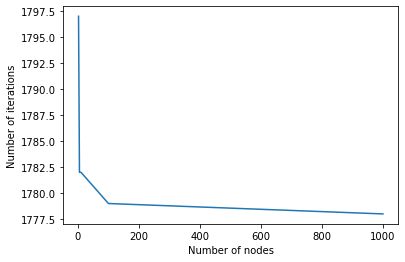

In [37]:
n_params = 10
topology = "dense"
func_type = "strongly convex"
max_iter = np.inf
lr = 1e-1
threshold = 1e-2

num_nodes = [2, 5, 10, 100, 1000]#list(range(2, 100, 20))

results = experiment(num_nodes, n_params, topology, func_type, max_iter, lr, threshold, number_exp = 1)

plotIter(num_nodes, results)

In [10]:
MetropolisHastings(buildTopology(5, "dense"))

array([[0. , 0.2, 0.2, 0.2, 0.2],
       [0.2, 0. , 0.2, 0.2, 0.2],
       [0.2, 0.2, 0. , 0.2, 0.2],
       [0.2, 0.2, 0.2, 0. , 0.2],
       [0.2, 0.2, 0.2, 0.2, 0. ]])

In [31]:
import time
time.time()

1655365234.729072